In [13]:
import pandas as pd
import numpy as np
import requests
import zipfile
import io

# 1. Download and unzip the HAR dataset from UCI
har_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip"
r = requests.get(har_url)
z = zipfile.ZipFile(io.BytesIO(r.content))

# 2. Read feature files:
#    - X_train.txt and y_train.txt
#    - X_test.txt and y_test.txt
# They are whitespace-separated, no header.

def read_har_file(path_within_zip):
    with z.open(path_within_zip) as f:
        return pd.read_csv(f, delim_whitespace=True, header=None)

X_train = read_har_file("UCI HAR Dataset/train/X_train.txt")
y_train = read_har_file("UCI HAR Dataset/train/y_train.txt")
X_test  = read_har_file("UCI HAR Dataset/test/X_test.txt")
y_test  = read_har_file("UCI HAR Dataset/test/y_test.txt")

# 3. Concatenate train + test
X_all = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)
y_all = pd.concat([y_train, y_test], axis=0).reset_index(drop=True)

# 4. Downsample to first 50 features (columns 0..49)
X_subset = X_all.iloc[:, :50]

# 5. Combine label column with features
df = X_subset.copy()
df.insert(0, "label", y_all[0])

# 6. Randomly sample 3000 rows if too large
if df.shape[0] > 3000:
    df = df.sample(n=3000, random_state=42).reset_index(drop=True)

# 7. Confirm shape (should be (3000, 51))
print("Final shape (rows, cols):", df.shape)

# 8. Save to space-delimited text (no header/index)
df.to_csv("myMLdataset_reduced.txt", sep=" ", header=False, index=False)
print("Saved myMLdataset_reduced.txt")


/var/folders/dy/8mm4s69x1mjcb909d7qg98mc0000gn/T/ipykernel_6569/2955829737.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(f, delim_whitespace=True, header=None)
/var/folders/dy/8mm4s69x1mjcb909d7qg98mc0000gn/T/ipykernel_6569/2955829737.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(f, delim_whitespace=True, header=None)
/var/folders/dy/8mm4s69x1mjcb909d7qg98mc0000gn/T/ipykernel_6569/2955829737.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(f, delim_whitespace=True, header=None)
/var/folders/dy/8mm4s69x1mjcb909d7qg98mc0000gn/T/ipykernel_6569/2955829737.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is de

Final shape (rows, cols): (3000, 51)
Saved myMLdataset_reduced.txt


In [14]:
df.head()

,label,0,1,2,3,4,5,6,7,8,...,40,41,42,43,44,45,46,47,48,49
0,1,0.202351,-0.021717,-0.111851,-0.332095,-0.114114,-0.309439,-0.382582,-0.161981,-0.308824,...,0.969862,-0.152897,0.095859,-0.975980,-0.984465,-0.976717,-0.976514,-0.985073,-0.974830,0.902112
1,6,0.282814,-0.016686,-0.110004,-0.994285,-0.973997,-0.988410,-0.994069,-0.978087,-0.989570,...,-0.475389,0.815944,0.600420,-0.996677,-0.997906,-0.994443,-0.997064,-0.997940,-0.994560,-0.541438
2,5,0.272529,-0.020954,-0.114472,-0.996784,-0.975906,-0.986597,-0.997029,-0.973735,-0.985556,...,0.925555,-0.315737,0.126426,-0.995146,-0.980977,-0.981278,-0.994934,-0.980790,-0.980796,0.852609
3,5,0.276408,-0.024315,-0.101067,-0.995663,-0.973317,-0.976591,-0.996090,-0.970965,-0.973102,...,0.925793,-0.312020,-0.057923,-0.996177,-0.978469,-0.970817,-0.996120,-0.978113,-0.969359,0.851938
4,1,0.306400,-0.013045,-0.064768,-0.180371,-0.099780,-0.002085,-0.204581,-0.082737,0.031456,...,0.928150,0.020774,-0.246484,-0.971445,-0.975438,-0.948533,-0.972616,-0.974513,-0.950164,0.861586


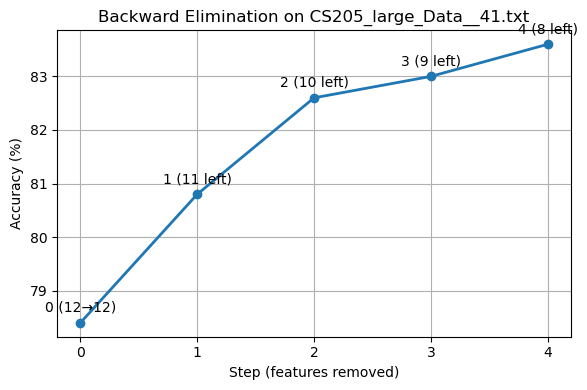

In [7]:
import re
import matplotlib.pyplot as plt

# Your backward‐elimination console text
output = """
Baseline (all features): 78.4%
→ Feature set {1,2,3,4,5,6,7,8,10,11,12} was best, accuracy is 80.8%
→ Feature set {1,3,4,5,6,7,8,10,11,12} was best, accuracy is 82.6%
→ Feature set {1,3,4,5,6,7,8,10,11} was best, accuracy is 83.0%
→ Feature set {1,3,4,5,6,7,8,10} was best, accuracy is 83.6%
"""

# Extract baseline and each “best” step
steps = []
accs  = []
labels = []   # to annotate x‐axis ticks

# Baseline
baseline = re.search(r'Baseline .*: ([0-9]*\.?[0-9]+)%', output)
if baseline:
    steps.append(0)
    accs.append(float(baseline.group(1)))
    labels.append("0 (12→12)")

# Each elimination step
pattern = re.compile(r'→ Feature set \{([0-9,]+)\} was best, accuracy is ([0-9]*\.?[0-9]+)%')
step = 1
for m in pattern.finditer(output):
    subset = m.group(1).split(',')
    acc    = float(m.group(2))
    steps.append(step)
    accs.append(acc)
    labels.append(f"{step} ({len(subset)} left)")
    step += 1

# Plot step vs accuracy
plt.figure(figsize=(6,4))
plt.plot(steps, accs, marker='o', linewidth=2)
for x, y, lbl in zip(steps, accs, labels):
    plt.annotate(lbl, (x, y), textcoords="offset points", xytext=(0,8), ha='center')

plt.title('Backward Elimination on CS205_large_Data__41.txt')
plt.xlabel('Step (features removed)')
plt.ylabel('Accuracy (%)')
plt.xticks(steps)  # [0,1,2,3,4]
plt.grid(True)
plt.tight_layout()
plt.show()
